<a href="https://colab.research.google.com/github/igorts-git/minesweeper-ai/blob/main/Minesweeper_Conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minesweeper solver using convolutions

### Minesweeper engine

In [ ]:
from engine import MinesweeperEngine, CellValue, CELL_STR
from enum import IntEnum
import random, copy, time
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# We will use GPU if it is available. Training will run several times faster on a GPU.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device=}")

device='cpu'


In [ ]:
eng = MinesweeperEngine(width=10, height=12, num_mines=40)
eng.partially_open(open_ratio=0.2)
print(eng.to_str(is_view_mask=True))
print(f"{eng.is_game_over=} open_ratio={eng.open_ratio():.2f}")
print(eng.to_tensor(is_view_mask=True, only_flags_vs_other=False))
print(eng.to_tensor(is_view_mask=False, only_flags_vs_other=False, mask_open=False))
print(eng.to_tensor(is_view_mask=False, only_flags_vs_other=True, mask_open=False))
print(eng.to_tensor(is_view_mask=False, only_flags_vs_other=True, mask_open=True))

2 ☐ 1 ☐ 2 ☐ ☐ ☐ ☐ ☐
☐ ☐ ☐ 1 ☐ ☐ 5 ☐ ☐ ☐
☐ ☐ ☐ 1 1 1 ☐ ☐ ☐ ☐
2 3 3 1   1 ☐ ☐ 2 ☐
☐ ☐ ☐ 3 1 3 ☐ 3 2 1
☐ 4 ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐
☐ ☐ ☐ ☐ ☐ 3 ☐ ☐ ☐ 1
☐ ☐ ☐ ☐ ☐ ☐ 1 1 ☐ ☐
☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐
☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐
☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐
☐ ☐ ☐ ☐ ☐ 4 ☐ ☐ ☐ ☐
eng.is_game_over=False open_ratio=0.22
tensor([[ 2, 10,  1, 10,  2, 10, 10, 10, 10, 10],
        [10, 10, 10,  1, 10, 10,  5, 10, 10, 10],
        [10, 10, 10,  1,  1,  1, 10, 10, 10, 10],
        [ 2,  3,  3,  1,  0,  1, 10, 10,  2, 10],
        [10, 10, 10,  3,  1,  3, 10,  3,  2,  1],
        [10,  4, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10,  3, 10, 10, 10,  1],
        [10, 10, 10, 10, 10, 10,  1,  1, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10,  4, 10, 10, 10, 10]])
tensor([[2, 9, 1, 1, 2, 9, 9, 9, 4, 9],
        [9, 3, 2, 1, 9, 3, 5, 9, 5, 9],
        [2, 9, 1, 1, 1, 1, 3, 9, 4, 1],


In [ ]:
def get_batch(batch_size, width=10, height=12):
    tensors = []
    targets = []
    for _ in range(batch_size):
        num_mines = random.randint(1, width*height//2)
        eng = MinesweeperEngine(width=width, height=height, num_mines=num_mines)
        eng.partially_open(open_ratio=0.2)
        tensor = eng.to_tensor(is_view_mask=True, only_flags_vs_other=False)
        tensors.append(tensor)
        targets.append(eng.to_tensor(is_view_mask=False, only_flags_vs_other=True, mask_open=True))
    return torch.stack(tensors), torch.stack(targets)

In [ ]:
VOCAB_SIZE = max(CellValue) + 1
EMBEDDING_WIDTH = 16
HIDDEN_WIDTH = 32
OPT_LEARNING_RATE = 5e-4
OPT_WEIGHT_DECAY = 0.01
OPT_BETAS = (0.9, 0.99)

In [ ]:
class PlayerModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(VOCAB_SIZE, EMBEDDING_WIDTH)
        self.conv1 = nn.Conv2d(in_channels=EMBEDDING_WIDTH, out_channels=HIDDEN_WIDTH, kernel_size=3, padding=2)
        self.tanh = nn.Tanh()
        self.conv2 = nn.Conv2d(in_channels=HIDDEN_WIDTH, out_channels=HIDDEN_WIDTH, kernel_size=3, padding=1, dilation=2)
        self.conv3 = nn.Conv2d(in_channels=HIDDEN_WIDTH, out_channels=2, kernel_size=1, padding=0)

    def forward(self, x: torch.Tensor, targets: torch.Tensor | None = None, print_debug=False) -> torch.Tensor:
        dim = x.ndim
        if dim == 2:
            x = x.unsqueeze(0)

        if print_debug:
            print(f"input shape: {x.shape}")

        x = self.emb(x)
        if print_debug:
            print(f"after emb shape: {x.shape}")

        x = x.permute(0, 3, 1, 2)
        if print_debug:
            print(f"after permute shape: {x.shape}")

        x = self.conv1(x)
        if print_debug:
            print(f"after conv1 shape: {x.shape}")

        x = self.tanh(x)
        if print_debug:
            print(f"after tanh shape: {x.shape}")

        x = self.conv2(x)
        if print_debug:
            print(f"after conv2 shape: {x.shape}")

        x = self.tanh(x)
        if print_debug:
            print(f"after tanh shape: {x.shape}")

        x = self.conv3(x)
        if print_debug:
            print(f"after conv3 shape: {x.shape}")

        logits = x
        loss = None
        if targets is not None:
            if targets.ndim == 2:
                targets = targets.unsqueeze(0)
            if print_debug:
                print(f"targets shape: {targets.shape}")
            loss = F.cross_entropy(logits, targets)
        if dim == 2:
            logits = logits.squeeze(0)
        return logits, loss

In [ ]:
with torch.no_grad():
    model = PlayerModel().to(device)
    num_params = sum((p.numel() for p in model.parameters()))
    print(f"Number of parameters: {num_params}")
    model.eval()
    X, Y = get_batch(3)
    logits, loss = model(X, targets=Y, print_debug=True)
    print(f"{logits.shape=} {loss.shape=}")

Number of parameters: 14178
input shape: torch.Size([3, 12, 10])
after emb shape: torch.Size([3, 12, 10, 16])
after permute shape: torch.Size([3, 16, 12, 10])
after conv1 shape: torch.Size([3, 32, 14, 12])
after tanh shape: torch.Size([3, 32, 14, 12])
after conv2 shape: torch.Size([3, 32, 12, 10])
after tanh shape: torch.Size([3, 32, 12, 10])
after conv3 shape: torch.Size([3, 2, 12, 10])
targets shape: torch.Size([3, 12, 10])
logits.shape=torch.Size([3, 2, 12, 10]) loss.shape=torch.Size([])


In [ ]:
class Trainer:
    def __init__(self, model: nn.Module):
        self.model = model
        self.step_counter = 0
        self.lossi = []  # Loss at every training step
        self.restart_steps = []  # At which step we restarted training.

    def do_train(self, num_steps, learning_rate=OPT_LEARNING_RATE):
        self.model.train()
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=OPT_WEIGHT_DECAY, betas=OPT_BETAS, eps=1e-8)
        print_freq = num_steps // 15
        self.restart_steps.append(self.step_counter)
        for iter in range(num_steps):
            start_t = time.time()
            X, Y = get_batch(32)
            batch_t = time.time()
            optimizer.zero_grad()
            _, loss = self.model(X, targets=Y)
            loss.backward()
            optimizer.step()
            self.lossi.append(loss.log10().item())
            end_t = time.time()
            if iter % print_freq == 0:
                step_time = end_t - start_t
                get_batch_time = batch_t - start_t
                with torch.no_grad():
                    self.model.eval()
                    X, Y = get_batch(128, width=32, height=32)
                    _, eval_loss = self.model(X, targets=Y)
                    self.model.train()
                eval_time = time.time() - end_t
                print(f"{self.step_counter=} {step_time=:.2f} {get_batch_time=:.2f} {eval_time=:.2f} {loss.item()=:.4f} {eval_loss.item()=:.4f}")
            self.step_counter += 1

trainer = Trainer(model)

In [ ]:
%%time
trainer.do_train(num_steps=10000, learning_rate=OPT_LEARNING_RATE)

self.step_counter=1000 step_time=0.09 get_batch_time=0.07 eval_time=19.06 loss.item()=0.5537 eval_loss.item()=0.5984
self.step_counter=1666 step_time=0.09 get_batch_time=0.07 eval_time=13.11 loss.item()=0.5747 eval_loss.item()=0.5582
self.step_counter=2332 step_time=0.09 get_batch_time=0.07 eval_time=12.39 loss.item()=0.5670 eval_loss.item()=0.5337
self.step_counter=2998 step_time=0.07 get_batch_time=0.05 eval_time=13.28 loss.item()=0.5163 eval_loss.item()=0.5367
self.step_counter=3664 step_time=0.08 get_batch_time=0.06 eval_time=13.15 loss.item()=0.5071 eval_loss.item()=0.5248
self.step_counter=4330 step_time=0.07 get_batch_time=0.05 eval_time=14.86 loss.item()=0.4803 eval_loss.item()=0.5419
self.step_counter=4996 step_time=0.08 get_batch_time=0.06 eval_time=14.66 loss.item()=0.5102 eval_loss.item()=0.5231
self.step_counter=5662 step_time=0.07 get_batch_time=0.05 eval_time=13.31 loss.item()=0.5018 eval_loss.item()=0.5159
self.step_counter=6328 step_time=0.09 get_batch_time=0.07 eval_t

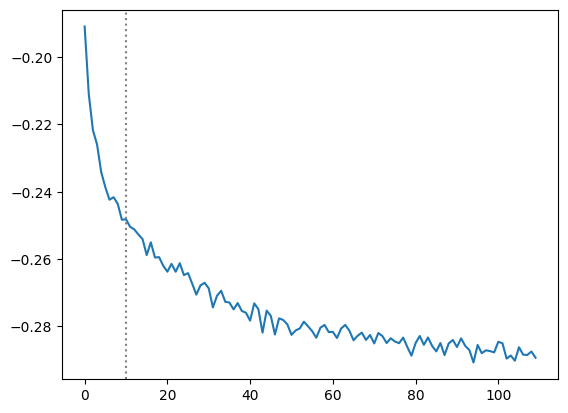

In [ ]:
smooth_over_steps = 100
plt.plot(torch.tensor(trainer.lossi).view(-1, smooth_over_steps).mean(1))
for x in trainer.restart_steps[1:]:
    plt.axvline(x//smooth_over_steps, linestyle=":", color="grey")

In [ ]:
def generate_move(model: nn.Module, eng: MinesweeperEngine) -> tuple[int, int, float]:
    with torch.no_grad():
        model.eval()
        tensor = eng.to_tensor(is_view_mask=True, only_flags_vs_other=False)
        logits, _ = model(tensor)
        probs = F.softmax(logits, dim=0)
        mask = (eng.to_tensor(is_view_mask=True, only_flags_vs_other=False) == CellValue.HIDDEN).float()
        probs = probs[0, :, :] * mask
        plt.imshow(probs)
        max_ind = torch.argmax(probs).item()
        x = max_ind % tensor.shape[1]
        y = max_ind // tensor.shape[1]
        return x, y, probs[y, x].item() * 100.0

    2 ☐ ☐ ☐ ☐ ☐ 2 ☐
1 2 3 ☐ ☐ ☐ ☐ ☐ 4 ☐
☐ ☐ ☐ 5 ☐ ☐ 4 ☐ ☐ ☐
☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐
☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐
☐ ☐ ☐ ☐ 4 4 ☐ ☐ ☐ 2
2 ☐ 4 ☐ ☐ ☐ ☐ 2 1 1
☐ ☐ ☐ 3 ☐ ☐ ☐ 1    
☐ ☐ ☐ 3 ☐ ☐ ☐ 2 1 1
☐ 2 ☐ ☐ ☐ ☐ ☐ ☐ ☐ 2
☐ ☐ 2 ☐ ☐ ☐ ☐ ☐ ☐ ☐
☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐
x=7 y=5 prob=97.75
    2 ☐ ☐ ☐ ☐ ☐ 2 ☐
1 2 3 ☐ ☐ ☐ ☐ ☐ 4 ☐
☐ ☐ ☐ 5 ☐ ☐ 4 ☐ ☐ ☐
☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐
☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐
☐ ☐ ☐ ☐ 4 4 ☐ 2 ☐ 2
2 ☐ 4 ☐ ☐ ☐ ☐ 2 1 1
☐ ☐ ☐ 3 ☐ ☐ ☐ 1    
☐ ☐ ☐ 3 ☐ ☐ ☐ 2 1 1
☐ 2 ☐ ☐ ☐ ☐ ☐ ☐ ☐ 2
☐ ☐ 2 ☐ ☐ ☐ ☐ ☐ ☐ ☐
☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐
x=7 y=9 prob=97.69
    2 ☐ ☐ ☐ ☐ ☐ 2 ☐
1 2 3 ☐ ☐ ☐ ☐ ☐ 4 ☐
☐ ☐ ☐ 5 ☐ ☐ 4 ☐ ☐ ☐
☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐
☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐
☐ ☐ ☐ ☐ 4 4 ☐ 2 ☐ 2
2 ☐ 4 ☐ ☐ ☐ ☐ 2 1 1
☐ ☐ ☐ 3 ☐ ☐ ☐ 1    
☐ ☐ ☐ 3 ☐ ☐ ☐ 2 1 1
☐ 2 ☐ ☐ ☐ ☐ ☐ 1 ☐ 2
☐ ☐ 2 ☐ ☐ ☐ ☐ ☐ ☐ ☐
☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐
x=7 y=10 prob=97.03
    2 ☐ ☐ ☐ ☐ ☐ 2 ☐
1 2 3 ☐ ☐ ☐ ☐ ☐ 4 ☐
☐ ☐ ☐ 5 ☐ ☐ 4 ☐ ☐ ☐
☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐
☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐
☐ ☐ ☐ ☐ 4 4 ☐ 2 ☐ 2
2 ☐ 4 ☐ ☐ ☐ ☐ 2 1 1
☐ ☐ ☐ 3 ☐ ☐ ☐ 1    
☐ ☐ ☐ 3 ☐ ☐ ☐ 2 1 1
☐ 2 ☐ ☐ ☐ ☐ ☐ 1 ☐ 2
☐ ☐ 2 ☐ ☐ ☐ ☐ 1 ☐ ☐
☐ 

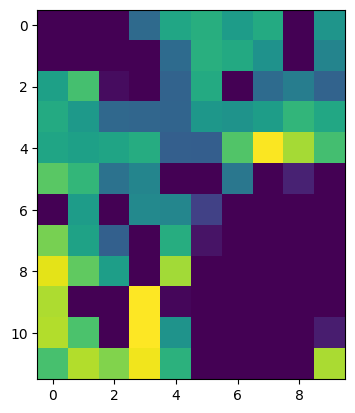

In [ ]:
eng = MinesweeperEngine(width=10, height=12, num_mines=40)
eng.partially_open(open_ratio=0.2)
print(eng.to_str(is_view_mask=True))
while not eng.is_game_over:
    x, y, prob = generate_move(model, eng)
    print(f"{x=} {y=} {prob=:.2f}")
    eng.open_cell(x, y)
    print(eng.to_str(is_view_mask=True))